# Inverse Sqrt of a Symmetric PSD Matrix $A$

We compare different techniques to compute the inverse sqrt of a symmetric PSD Matrix $A$, i.e., $A^{-\frac{1}{2}}$.
We begin be generating a random PSD matrix $A \in \mathbb{R}^{1000 \times 1000}$ and evaluating $A^{-\frac{1}{2}}$ accurately using the eigendecomposition of $A$:
$A^{-\frac{1}{2}} = V \Lambda^{-\frac{1}{2}} V^T$.
We then continue with the other techniques and evaluate their accuracy and runtime. 

In [82]:
from torch import nn
from timeit import default_timer as timer
import matplotlib.pyplot as plt

from matrix_inv_sqrt import random_symmetric_psd_matrix, inv_sqrt_through_eigendecomposition, ComputePower


mse_fn = nn.MSELoss()

In [83]:
A = random_symmetric_psd_matrix(1000)
inv_sqrt = inv_sqrt_through_eigendecomposition(A)
inv_sqrt_newton = ComputePower(A.clone(), 2, ridge_epsilon=1e-10)

In [96]:
num_iters = 50
eigendecomposition_runtime = []
start = timer()
for i in range(num_iters):
    inv_sqrt = inv_sqrt_through_eigendecomposition(A)
end = timer()
eigendecomposition_runtime = (end - start) / num_iters
print(f'Eigendecomposition runtime {eigendecomposition_runtime}')

Eigendecomposition runtime 0.04151415799977258


# Cholesky Factorization

Note that Cholesky factorization returns a matrix $L$ such that $A = L L^T$.
However, $A \neq L L$.
Hence, $L \neq A^{\frac{1}{2}}$ and therefore $L^{-1} \neq A^{-\frac{1}{2}}$.
As a result, Cholesky cannot be used to evaluate $A^{-\frac{1}{2}}$ directly.
By using additional polar decomposition of $L$, such that $L=HU$ for symmetric $H$ and orthogonal $U$, we can get $A^{-\frac{1}{2}} = L^{-1}U$.
See https://math.stackexchange.com/questions/1230051/inverse-square-root-of-matrix for a proof.

# Newton's Method

Newton's method is an iterative algorithm, and its accuracy improves when using more iterations.
The parameter that controls then number of iterations is `iter_count`.
In addition to `iter_count` there are additional two other parameters - `ridge_epsilon` and `error_tolerance`.
The `ridge_epsilon` helps getting the given positive semi definite matrix positive definite and smaller value will obtain a more accurate results as it keeps the matrix closer to the original one.
The `error_tolerance` is used for early exit; if the error is smaller than the `error_tolerance`, even if number of iterations is smaller than `iter_count` the algorithm finishes.

## Accuracy as a function of `ridge_epsilon`, `iter_count`, and `error_tolerance`

In theses experiments we explore the effect of the three parameters (separately) on the accuracy of the algorithm.
We have the accurate inverse sqrt of $A$ and we compare the output of Newton's method to it.
The metric to measure the accuracy is MSE.

In [72]:
ridge_epsilons = [10**(-x) for x in range(1, 15)]
ridge_epsilon_mse_arr = []
for ridge_epsilon in ridge_epsilons:
    inv_sqrt_newton = ComputePower(A.clone(), 2, ridge_epsilon=ridge_epsilon)
    mse = mse_fn(inv_sqrt, inv_sqrt_newton)
    ridge_epsilon_mse_arr.append(mse.cpu())

In [73]:
iter_counts = range(1, 101)
iter_count_mse_arr = []
for iter_count in iter_counts:
    inv_sqrt_newton = ComputePower(A.clone(), 2, iter_count=iter_count, ridge_epsilon=1e-10)
    mse = mse_fn(inv_sqrt, inv_sqrt_newton)
    iter_count_mse_arr.append(mse.cpu())

In [74]:
error_tolerances = [10**(-x) for x in range(1, 15)]
error_tolerance_mse_arr = []
for error_tolerance in error_tolerances:
    inv_sqrt_newton = ComputePower(A.clone(), 2, error_tolerance=error_tolerance, ridge_epsilon=1e-10)
    mse = mse_fn(inv_sqrt, inv_sqrt_newton)
    error_tolerance_mse_arr.append(mse.cpu())

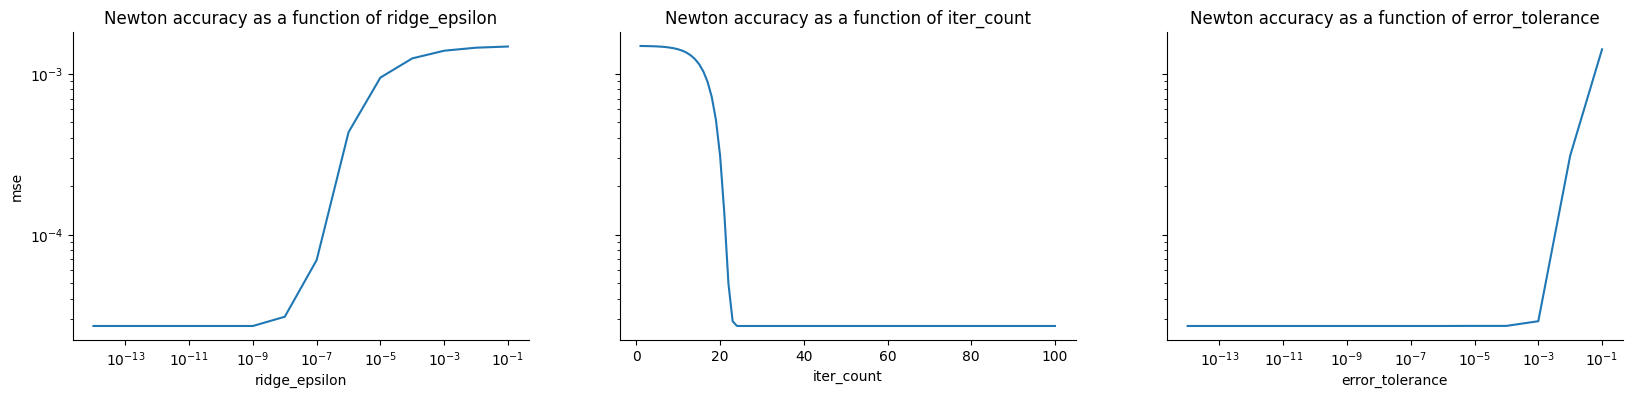

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
axs[0].plot(ridge_epsilons, ridge_epsilon_mse_arr)
axs[0].set_xlabel('ridge_epsilon')
axs[0].set_ylabel('mse')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title('Newton accuracy as a function of ridge_epsilon')

axs[1].plot(iter_counts, iter_count_mse_arr)
axs[1].set_xlabel('iter_count')
axs[1].set_yscale('log')
axs[1].set_title('Newton accuracy as a function of iter_count')

axs[2].plot(error_tolerances, error_tolerance_mse_arr)
axs[2].set_xlabel('error_tolerance')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_title('Newton accuracy as a function of error_tolerance')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.show(block=False)

## Runtime as a function of `iter_count` (for small error_tolerance, such that iter_count is the effective stopping condition)

Newton's method is an iterative algorithm, and its accuracy improves when using more iterations.
Hence, there is a tradeoff between accuracy and runtime.
The parameter that controls the number of iterations is `iter_count`.
In this experiment we test the impact of `iter_count` on the runtime of the algorithm.

In [85]:
num_iters = 20
iter_counts = range(0, 200, 5)
runtime_arr = []
for iter_count in iter_counts:
    start = timer()
    for i in range(num_iters):
        inv_sqrt_newton = ComputePower(A.clone(), 2, iter_count=iter_count+1, ridge_epsilon=1e-10, error_tolerance=1e-14)
    end = timer()
    runtime_arr.append((end - start) / num_iters)
    if iter_count % 20 == 0:
        print(f'Completed {iter_count}')

Completed 0
Completed 20
Completed 40
Completed 60
Completed 80
Completed 100
Completed 120
Completed 140
Completed 160
Completed 180


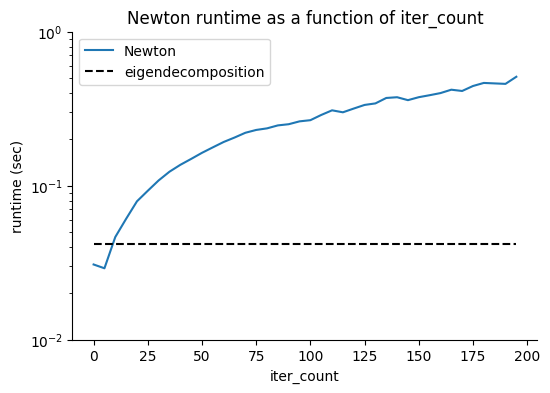

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(iter_counts, runtime_arr, label='Newton')
# Horizontal line for the eigendecomposition runtime
ax.hlines(eigendecomposition_runtime, iter_counts[0], iter_counts[-1], colors='black', linestyles='--', label='eigendecomposition')
ax.set_xlabel('iter_count')
ax.set_ylabel('runtime (sec)')
ax.set_yscale('log')
ax.set_yticks((10**-2, 0.1, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Newton runtime as a function of iter_count')
ax.legend()
plt.show(block=False)